In [108]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [109]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [110]:
import nntools as nt

In [111]:
class NN(nt.NeuralNetwork):
    def __init__(self):
        super(NN, self).__init__()
        self.MSE = nn.MSELoss(size_average=None, reduce=None, reduction='sum')
    def criterion(self, y, d):
        return self.MSE(y, d)

In [112]:
vgg = tv.models.vgg19(pretrained=True)
# resnet = tv.models.resnet18(pretrained=True)
# print(resnet)

In [113]:
# Define the VGG network with transfer learning
class VGG19Transfer(NN):
    def __init__(self, fine_tuning=False): #want to keep existing weights/biases
        super(VGG19Transfer, self).__init__()
        vgg = tv.models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        # Only maintain the feature space    
        self.net = nn.ModuleList()
        self.net = vgg.features
        # Change MaxPool to AvgPool
        self.net[4] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[9] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[18] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[27] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[36] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
 
    def forward(self, x):
        rep = {}
        rep['c11'] = self.net[0](x)
        rep['r11'] = F.relu(rep['c11'] )
        rep['c12'] = self.net[2](rep['r11'] )
        rep['r12'] = F.relu(rep['r11'] )
        rep['p1'] = self.net[4](rep['c12'] )
        rep['c21'] = self.net[5](rep['p1'] )
        rep['r21'] = F.relu(rep['c21'] )
        rep['c22'] = self.net[7](rep['r21'] )
        rep['r22'] = F.relu(rep['c22'] )
        rep['p2'] = self.net[9](rep['r22'] )
        rep['c31'] = self.net[10](rep['p2'] )
        rep['r31'] = F.relu(rep['c31'] )
        rep['c32'] = self.net[12](rep['r31'] )
        rep['r32'] = F.relu(rep['c32'] )
        rep['c33'] = self.net[14](rep['r32'] )
        rep['r33'] = F.relu(rep['c33'] )
        rep['c34'] = self.net[16](rep['r33'] )
        rep['r34'] = F.relu(rep['c34'] )
        rep['p3'] = self.net[18](rep['r34'] )
        rep['c41'] = self.net[19](rep['p3'] )
        rep['r41'] = F.relu(rep['c41'] )
        rep['c42'] = self.net[21](rep['r41'] )
        rep['r42'] = F.relu(rep['c42'] )
        rep['c43'] = self.net[23](rep['r42'] )
        rep['r43'] = F.relu(rep['c43'] )
        rep['c44'] = self.net[25](rep['r43'] )
        rep['r44'] = F.relu(rep['c44'] )
        rep['p4'] = self.net[27](rep['r44'] )
        rep['c51'] = self.net[28](rep['p4'] )
        rep['r51'] = F.relu(rep['c51'] )
        rep['c52'] = self.net[30](rep['r51'] )
        rep['r52'] = F.relu(rep['c52'] )
        rep['c53'] = self.net[32](rep['r52'] )
        rep['r53'] = F.relu(rep['c53'] )
        rep['c54'] = self.net[34](rep['r53'] )
        rep['r54'] = F.relu(rep['c54'] )
        rep['p5'] = self.net[36](rep['r11'] )
        
        return rep #dictionary data structure; can change if you guys have better ideas

In [105]:
# # Define the ResNet network with transfer learning (EXPERIMENT)
# class ResNet18Transfer(NN):
#     def __init__(self, fine_tuning=False): #want to keep existing weights/biases
#         super(ResNet18Transfer, self).__init__()
#         resnet = tv.models.resnet18(pretrained=True)
#         for param in resnet.parameters():
#             param.requires_grad = fine_tuning
        
#         self.net = nn.ModuleList()
#         self.net.append(resnet.conv1) #0
#         self.net.append(resnet.bn1) #1
#         self.net.append(resnet.relu) #2
#         self.net.append(torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False))
#         self.net.append(resnet.layer1) #4
#         self.net.append(resnet.layer2) #5
#         self.net.append(resnet.layer3) #6
#         self.net.append(resnet.layer4)#7
        
#     def forward(self, x):
        
# #         rep = {}
# #         rep['l1'] = self.net[:4](x)
# #         rep['l1'] = self.net[4][0].conv1(rep['l1'])
        
# #         rep['l2'] = self.net[:5](x)
# #         rep['l2'] = self.net[5][0].conv1(rep['l2'])
        
# #         rep['l3'] = self.net[:6](x)
# #         rep['l3'] = self.net[6][0].conv1(rep['l3'])
        
# #         rep['l4'] = self.net[:7](x)
# #         rep['l4'] = self.net[7][0].conv1(rep['l4'])
        
#         rep = self.net(x)
        
# #         rep['l2'] = self.net[:6].conv1(x)
# #         rep['l3'] = self.net[:8].conv1(x)
# #         rep['l4'] = self.net[:10].conv1(x)
# #         rep['c1'] = self.conv1(x)
# #         rep['bn1'] = self.bn1(rep['c1'])
# #         rep['relu'] = self.relu(rep['bn1'])
# #         rep['avgpool'] = self.avgpool(rep['relu'])
# #         passthis1 = self.layer1(rep['avgpool'])
# #         passthis2 = (self.layer2(passthis1))
# #         passthis3 = (self.layer3(passthis2))
# #         passthis4 = (self.layer4(passthis3))
# #         rep['l1'] = (self.layer1[0].conv1(rep['avgpool']))
# #         rep['l2'] = (self.layer2[0].conv1(passthis1))
# #         rep['l3'] = (self.layer3[0].conv1(passthis3))
# #         rep['l4'] = (self.layer4[0].conv1(passthis4))

        
#         return rep 

In [114]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [115]:
def Gram(featresp):
    return torch.mm(featresp,featresp.t()) # NlxNl (from paper)

In [133]:
# get images and initialize the network
transform = tv.transforms.Compose([
    tv.transforms.Resize((512)), #whatever size we want i guess?
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.485, 0.456, 0.406], #mean and std from ImageNet dataset used for VGG
                        [0.229, 0.224, 0.225]),
    ])
invtrans = tv.transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

photo_path = 'Content.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:] # add a singleton dimension for the batch size

art_path = 'Art.jpg'
art = Image.open(art_path)
a = (transform(art))
a = a[None,:,:,:]

p = p.to(device)
a = a.to(device)
net = VGG19Transfer().to(device)

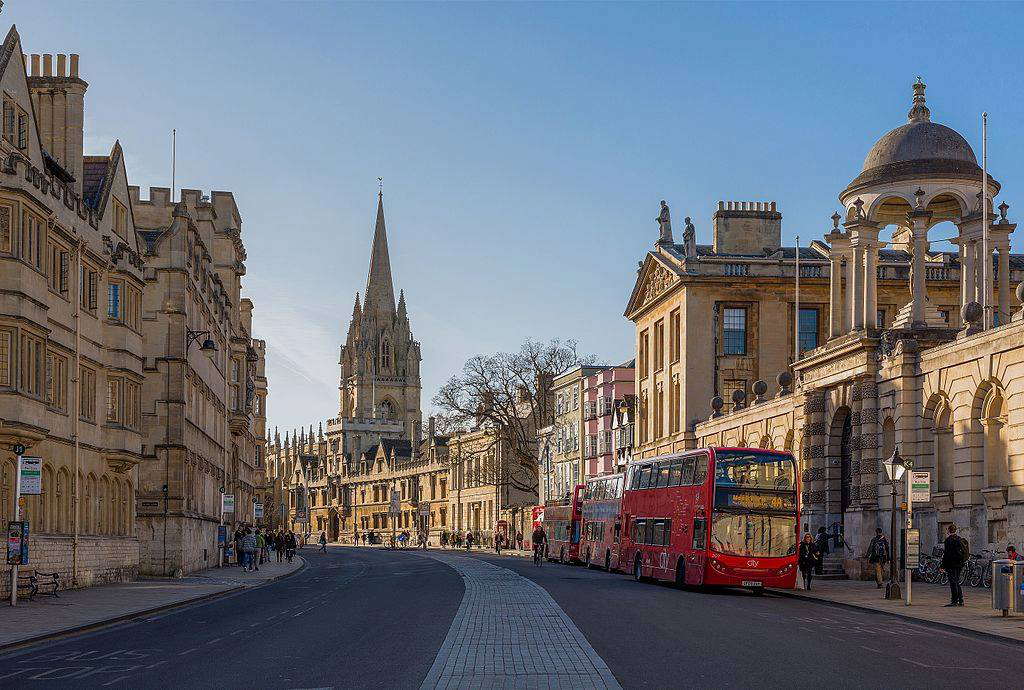

In [152]:
# this is the content image
photo

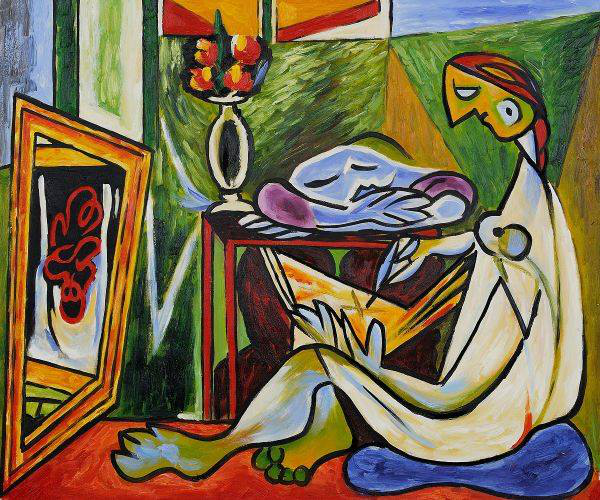

In [151]:
# this is the art image
art

<IPython.core.display.Javascript object>


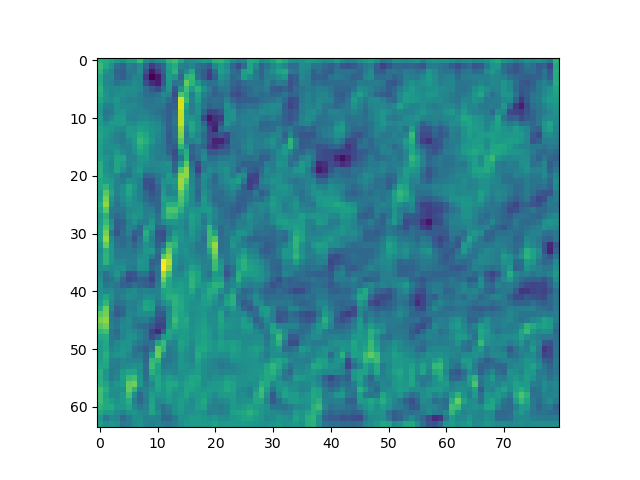

In [132]:
#Visualize various feature representations
tt = net(a)
b = tt['c42'].detach().cpu()
bb = b[0,4,:,:] #2nd axis is different feature map of layer defined above as b = tt['layer']
bb.numpy()
plt.imshow(bb.numpy()) # look at the feature map!

In [224]:
# Initialize the white noise image to be the same dimension as the photo.
h = p.shape[2]
w = p.shape[3]
x = torch.randn(1,3,h,w,requires_grad=True,device='cuda')
losshistory = []

In [225]:
# # transfer the style my dude using the Adam optimizer
# epochs = 500

# optimizer = torch.optim.Adam([x], lr=0.01, betas=(0.9, 0.999))

# P = net.forward(p)
# P42NL = P['r42'].shape[1]
# P42 = P['r42'].view(P42NL,-1)

# A = net.forward(a) 
# A1 = A['r11'].view(64,-1)
# A2 = A['r21'].view(128,-1)
# A3 = A['r31'].view(256,-1)
# A4 = A['r41'].view(512,-1)
# A5 = A['r51'].view(512,-1)

# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))


# for epoch in range(epochs):
#     optimizer.zero_grad()

#     outputs = net.forward(x)

#     out42 = outputs['r42'].view(P42NL, -1)

#     out1 = outputs['r11'].view(64,-1)
#     out2 = outputs['r21'].view(128,-1)
#     out3 = outputs['r31'].view(256,-1)
#     out4 = outputs['r41'].view(512,-1)
#     out5 = outputs['r51'].view(512,-1)

#     #get content loss
#     contentloss = net.criterion(out42,P42)/2

#     #get style gram matrices
#     gram1 = Gram(out1)
#     gram2 = Gram(out2)
#     gram3 = Gram(out3)
#     gram4 = Gram(out4)
#     gram5 = Gram(out5)

#     gram1o = Gram(A1)
#     gram2o = Gram(A2)
#     gram3o = Gram(A3)
#     gram4o = Gram(A4)
#     gram5o = Gram(A5)

#     #style loss
#     E1 = 1/(4*(out1.shape[0])**2*(out1.shape[1])**2) * net.criterion(gram1,gram1o)
#     E2 = 1/(4*(out2.shape[0])**2*(out2.shape[1])**2) * net.criterion(gram2,gram2o)
#     E3 = 1/(4*(out3.shape[0])**2*(out3.shape[1])**2) * net.criterion(gram3,gram3o)
#     E4 = 1/(4*(out4.shape[0])**2*(out4.shape[1])**2) * net.criterion(gram4,gram4o)
#     E5 = 1/(4*(out5.shape[0])**2*(out5.shape[1])**2) * net.criterion(gram5,gram5o)

#     #total style loss
# #         styleloss = E1*1e3/(64**2) + E2*1e3/(128**2) + E3*1e3/(256**2) + E4*1e3/(512**2) + E5*1e3/(512**2)
#     styleloss = (E1+E2+1*E3+E4+E5)/5

#     #get total loss
#     loss = contentloss + 60000000*styleloss

#     #backprop
#     loss.backward(retain_graph=True)

#     #parameter search
#     optimizer.step()
    
#     #display during optimization
#     if epoch % 10 == 0:
#         lo = loss.detach().cpu()
#         losshistory.append(lo)
# #         print('loss',loss)
#         print(epoch)
#         axes.clear()
#         xx = x.detach().cpu()
#         hh = x.shape[2]
#         xx = xx.view(3,h,-1)
#         myimshow(xx)
#     plt.tight_layout()
#     fig.canvas.draw()

# #     return x

In [226]:
# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))
# axes.plot(losshistory)
# plt.ylabel('Loss')
# plt.xlabel('Epochs (10) ')
# plt.savefig('gatys_adam_60000000_loss.png')

<IPython.core.display.Javascript object>


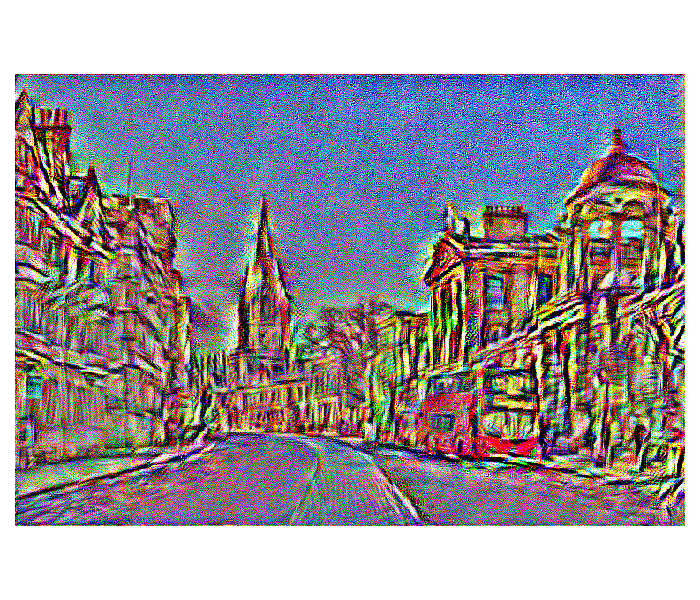

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [227]:
# transfer the style my dude for LBFGS optimizer
epochs = 500

optimizer = torch.optim.LBFGS([x], lr=0.01)

P = net.forward(p)
P42NL = P['r42'].shape[1]
P42 = P['r42'].view(P42NL,-1)

A = net.forward(a) 
A1 = A['r11'].view(64,-1)
A2 = A['r21'].view(128,-1)
A3 = A['r31'].view(256,-1)
A4 = A['r41'].view(512,-1)
A5 = A['r51'].view(512,-1)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

for epoch in range(epochs):
    def closure():
        optimizer.zero_grad()

        outputs = net.forward(x)

        out42 = outputs['r42'].view(P42NL, -1)

        out1 = outputs['r11'].view(64,-1)
        out2 = outputs['r21'].view(128,-1)
        out3 = outputs['r31'].view(256,-1)
        out4 = outputs['r41'].view(512,-1)
        out5 = outputs['r51'].view(512,-1)

        #get content loss
        contentloss = net.criterion(out42,P42)/2

        #get style gram matrices
        gram1 = Gram(out1)
        gram2 = Gram(out2)
        gram3 = Gram(out3)
        gram4 = Gram(out4)
        gram5 = Gram(out5)

        gram1o = Gram(A1)
        gram2o = Gram(A2)
        gram3o = Gram(A3)
        gram4o = Gram(A4)
        gram5o = Gram(A5)

        #style loss
        E1 = 1/(4*(out1.shape[0])**2*(out1.shape[1])**2) * net.criterion(gram1,gram1o)
        E2 = 1/(4*(out2.shape[0])**2*(out2.shape[1])**2) * net.criterion(gram2,gram2o)
        E3 = 1/(4*(out3.shape[0])**2*(out3.shape[1])**2) * net.criterion(gram3,gram3o)
        E4 = 1/(4*(out4.shape[0])**2*(out4.shape[1])**2) * net.criterion(gram4,gram4o)
        E5 = 1/(4*(out5.shape[0])**2*(out5.shape[1])**2) * net.criterion(gram5,gram5o)

        #total style loss
        #styleloss = E1*1e3/(64**2) + E2*1e3/(128**2) + E3*1e3/(256**2) + E4*1e3/(512**2) + E5*1e3/(512**2)
        styleloss = (E1+E2+E3+E4+E5)/5

        #get total loss
        loss = contentloss + 600000*styleloss
        
        #backprop
        loss.backward(retain_graph=True)
        return loss

    

    #parameter search
    optimizer.step(closure)
    
    #display during optimization
    if epoch % 10 == 0:
        lo = closure().detach().cpu()
        losshistory.append(lo)
#         print(closure()) # print loss
        print(epoch)
        axes.clear()
        xx = x.detach().cpu()
        hh = x.shape[2]
        xx = xx.view(3,h,-1)
        myimshow(xx)
    plt.tight_layout()
    fig.canvas.draw()

#     return x

<IPython.core.display.Javascript object>


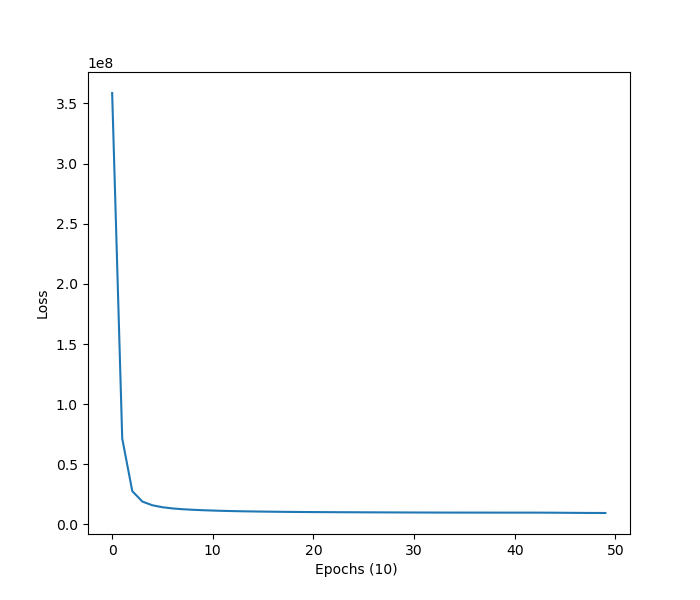

In [222]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))
axes.plot(losshistory)
plt.ylabel('Loss')
plt.xlabel('Epochs (10) ')
# plt.savefig('gatys_LBFGS_6e7_loss.png')

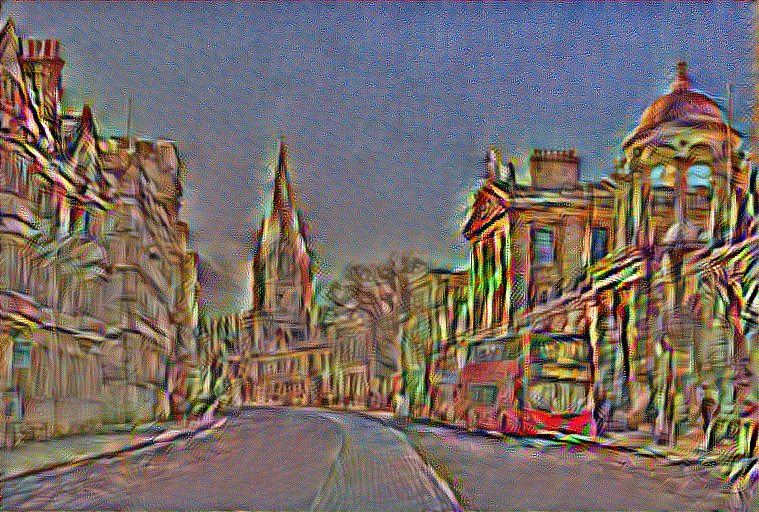

In [228]:
# Inverse normalize the output image to save
xx = x.detach()
xx = invtrans(xx[0])
xx[xx>1] = 1
xx[xx<0] = 0
xxx = tv.transforms.ToPILImage()(xx.cpu())
# xxx.save("gatys_LBFSG_6e5.jpg")
xxx